In [1]:
import torch
import numpy as np
import scipy as sp
from scipy import signal

from _independent_component_analysis import SOBI, SlowFlows
from _flow_model import *
from _util import time_lagged_autocov
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

### Data generation

In [2]:
import scipy as sp
from scipy import signal

np.random.seed(0)
n_samples = 4000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal

irregular_time = [0]
for _ in time[1:]:
    irregular_time.append(irregular_time[-1] + np.random.randint(5) + 1)
    
irregular_time = np.array(irregular_time) / n_samples * 8

s2 = np.sign(np.sin(3 * irregular_time))  # Signal 2 : square signal

irregular_time = [0]
for _ in time[1:]:
    irregular_time.append(irregular_time[-1] + np.random.randint(5) + 1)
    
irregular_time = np.array(irregular_time) / n_samples * 8

s3 = signal.sawtooth(2 * np.pi * irregular_time)  # Signal 3: saw tooth signal
s4 = np.arange(-1, 1, 2/n_samples)

S = np.c_[s1, s2, s3, s4]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
S = (S - S.min(axis=0, keepdims=True)) / (S.max(axis=0, keepdims=True) - S.min(axis=0, keepdims=True))  # Standardize data
# Mix data
A = np.array([[1, 1, 1, 1], [0.5, 2, 1.0, 0.5], [1.5, 1.0, 2.0, 1.5], [-0.5, 1, 0.2, 0.5]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

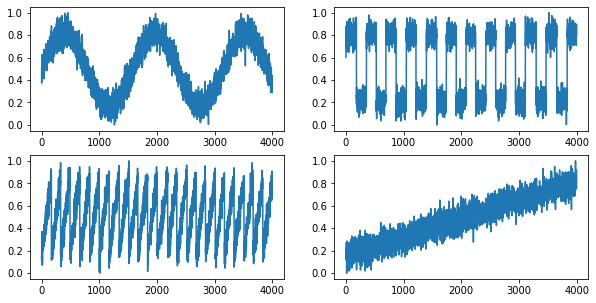

In [3]:
plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S[:, i])

### Non-linear mixing with a randomly initialized flow-based model

In [4]:
class FlowModel(LayerList, nn.Module):
    
    """ **FlowModel**: example of flow-based model architecture class.
    
        Parameters
        ----------
            * D: dimension of the input
            * NN: neural networks used in the **AffineCoupling**
            * depth: depth of the flow-based model (number of FlowLayers)
    """
    
    def __init__(self, D, NN, depth=1):
        super(FlowModel, self).__init__()
        self.D = D
        self.depth = depth
        
        layers = []
        for d in range(depth):
            shuffled_layer = Shuffle(D)
            layers.append(shuffled_layer)
            layers.append(ActivationNormalization(D))
            layers.append(AffineCoupling(D, NN()))
        
        layers.append(Prior(torch.zeros(1, D), torch.zeros(1, D)))
        self.layers = nn.ModuleList(layers)

In [5]:
S = torch.FloatTensor(S)
D = S.size(-1)
NN = lambda: nn.Sequential(nn.Linear(D//2, D))

mixture = FlowModel(D, NN, 10).to(device)

previous_loss = torch.zeros(S.size(0)).to(device)
    
X_nl = mixture.to_embedding(S, previous_loss)[0].cpu().detach().numpy()

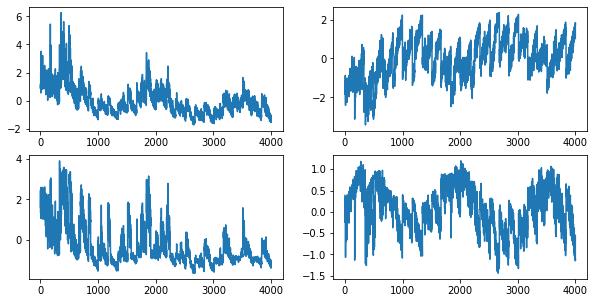

In [6]:
plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(X_nl[:, i])

### Test linear ICA to see that it fails

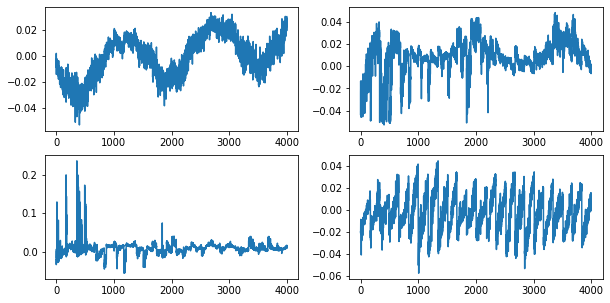

In [7]:
ica = SOBI(100)
S_estimated = ica.fit_transform(X_nl)

plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S_estimated[:, i])

In [8]:
previous_loss = torch.zeros(S.size(0)).to(device)
results= []

for _ in range(20):
    mixture = FlowModel(D, NN, 10).to(device)
    X_nl = mixture.to_embedding(S, previous_loss)[0].cpu().detach().numpy()
    S_estimated = ica.fit_transform(X_nl)
    results.append(np.abs(np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4]).max(1).mean())
    
print(np.mean(results), np.std(results))

0.5571119034328127 0.05387625441446907


We see that the mixing is effectively **not** linearly identifiable. 

### Unmixing with slow-FBM

We first define the flow-based unmixing model

In [9]:
class FlowModel(LayerList, nn.Module):
    
    """ **FlowModel**: example of flow-based model architecture class. """
    
    def __init__(self, D, NN, depth=1, trainable_variance=True):
        
        """ 
        
        Model initialization.
    
        Parameters
        ----------
            * D: dimension of the input
            * NN: neural networks used in the **AffineCoupling**
            * depth: depth of the flow-based model (number of FlowLayers)
            * trainable_variance: possibility to learn the variance parameters of the increment Gaussian distribution
                                  We remind that the theoretical results assume infinte data.
                                  In this toy example, we have not infinte data at all.
                                  The trainable variance for increment distribution gives more robust results in low data setup.
        """
        
        super(FlowModel, self).__init__()
        self.D = D
        self.depth = depth
        
        if trainable_variance:
            self.scales = nn.ParameterList([nn.Parameter(torch.ones(D), requires_grad=(i!=0)) for i in range(2)])
        else:
            self.scales = nn.ParameterList([nn.Parameter(torch.ones(D), requires_grad=False) for i in range(2)])
        
        layers = []
        for d in range(depth):
            shuffled_layer = Shuffle(D)
            layers.append(shuffled_layer)
            layers.append(ActivationNormalization(D))
            layers.append(AffineCoupling(D, NN()))
            layers.append(shuffled_layer)
            layers.append(ActivationNormalization(D))
            layers.append(AffineCoupling(D, NN()))
        
        layers.append(Linear(D))
        self.layers = nn.ModuleList(layers)

In [10]:
NN = lambda: nn.Sequential(nn.Linear(D//2, 16), nn.LeakyReLU(), 
                           nn.Linear(16, D))

flowModel = FlowModel(D, NN, 12)
flowModel = flowModel.to(device)

slow_flows = SlowFlows(D, flowModel)

In [11]:
X_nl = torch.FloatTensor(X_nl).unsqueeze(0)

In [12]:
slow_flows.fit(X_nl, batch_size=10, num_epochs=1500)

iter 0: loss = 12.061
iter 10: loss = 18.349
iter 20: loss = 16.760
iter 30: loss = 15.821
iter 40: loss = 15.131
iter 50: loss = 14.625
iter 60: loss = 14.262
iter 70: loss = 13.962
iter 80: loss = 13.688
iter 90: loss = 13.451
iter 100: loss = 13.239
iter 110: loss = 13.043
iter 120: loss = 12.859
iter 130: loss = 12.686
iter 140: loss = 12.527
iter 150: loss = 12.380
iter 160: loss = 12.250
iter 170: loss = 12.121
iter 180: loss = 12.004
iter 190: loss = 11.896
iter 200: loss = 11.791
iter 210: loss = 11.693
iter 220: loss = 11.601
iter 230: loss = 11.513
iter 240: loss = 11.424
iter 250: loss = 11.344
iter 260: loss = 11.264
iter 270: loss = 11.183
iter 280: loss = 11.115
iter 290: loss = 11.035
iter 300: loss = 10.970
iter 310: loss = 10.902
iter 320: loss = 10.834
iter 330: loss = 10.755
iter 340: loss = 10.688
iter 350: loss = 10.624
iter 360: loss = 10.563
iter 370: loss = 10.504
iter 380: loss = 10.452
iter 390: loss = 10.382
iter 400: loss = 10.329
iter 410: loss = 10.272
ite

The previous loss is specific to the Abstract Class design of the FlowBased model.

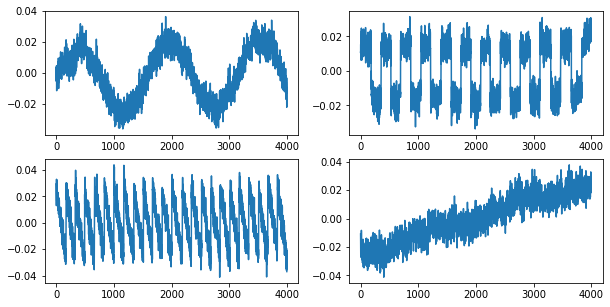

In [14]:
S_estimated = slow_flows.transform(X_nl)

corr = np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4]
max_cor = np.argmax(np.abs(corr), axis=0)

plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S_estimated[:, max_cor[i]])

Plot the estimated sources

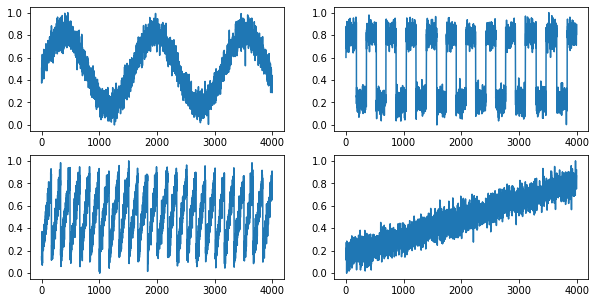

In [15]:
plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S[:, i])

Correlation with the true sources

In [16]:
np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4]

array([[ 9.63485774e-01,  6.50780188e-03, -1.82928313e-02,
         1.21348153e-01],
       [-1.45790737e-01, -5.17612148e-02, -5.42589936e-04,
         9.67386664e-01],
       [-7.07039519e-03, -2.75557634e-02, -9.74380883e-01,
        -2.98470609e-02],
       [-2.42923083e-02,  9.78600398e-01, -9.23283548e-03,
         4.67403827e-02]])

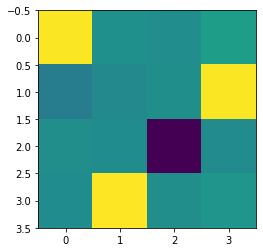

In [17]:
plt.imshow(np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4])

Mean absolute correlation

In [18]:
np.abs(np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4]).max(1).mean()

0.9709634298510307